In [9]:
print("directional")

directional


In [10]:
from utils import draw_graph, draw_graph_nodes

In [11]:
class DirectedGraph:
    def __init__(self, labels) -> None:
        self.labels = labels  # ["a", "b", "c"]
        self.num_vertices = len(labels)
        self.adj_matrix = [[0] * self.num_vertices for _ in range(self.num_vertices)]
        # [
        #  [0, 1, 0],
        #  [0, 0, 0],
        #  [0, 0, 0]
        #  ]

    def label_to_index(self, label):
        if label not in self.labels:
            raise ValueError(f"label {label} not found in graph")
        return self.labels.index(label)

    def add_edge(self, label1, label2, weight=1):  # g.add_edge("a", "b")
        u = self.label_to_index(label1)  # 0
        v = self.label_to_index(label2)  # 1
        self.adj_matrix[u][v] = weight

    def remove_edge(self, label1, label2):
        u = self.label_to_index(label1)
        v = self.label_to_index(label2)
        self.adj_matrix[u][v] = 0

    def detect_cycle(self):
        # Keeps track of every node we've ever finished exploring.
        visited = [False] * self.num_vertices

        # Tracks nodes in the *current* recursion depth (the path we are currently exploring). This is the trail of "breadcrumbs".
        recursion_stack = [False] * self.num_vertices

        def dfs_helper(curr):
            # Step 2: Mark the node as visited so it isn't picked as a starting point again.
            visited[curr] = True

            # Step 3: Add the node to our current path.
            recursion_stack[curr] = True

            # Step 4: Check every possible node to see if it's a neighbor.
            for neighbor in range(self.num_vertices):
                if self.adj_matrix[curr][neighbor] != 0:

                    # Case A: If the neighbor hasn't been visited at all, dive into it.
                    if not visited[neighbor]:
                        is_cycle = dfs_helper(neighbor)
                        if is_cycle:
                            # If a cycle was found deeper in the recursion, pass it up.
                            return True

                    # Case B: If the neighbor is in the 'recursion_stack', we found a Back Edge - a way back.
                    # We came back to a visited place, one with breadcrumbs on it.
                    elif recursion_stack[neighbor]:
                        return True

            # Step 5: BACKTRACKING.
            # We are done exploring all paths from 'curr'. Remove it from the current path
            # so it doesn't interfere with other branches of the DFS.
            recursion_stack[curr] = False
            return False

        # Step 1: Main loop to handle disconnected components or multiple start nodes.
        for vertex in range(self.num_vertices):
            # If we haven't touched this node yet, start a DFS from it.
            if not visited[vertex]:
                if dfs_helper(vertex):
                    return True

        # If no cycles were found after checking every node.
        return False

[[0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]


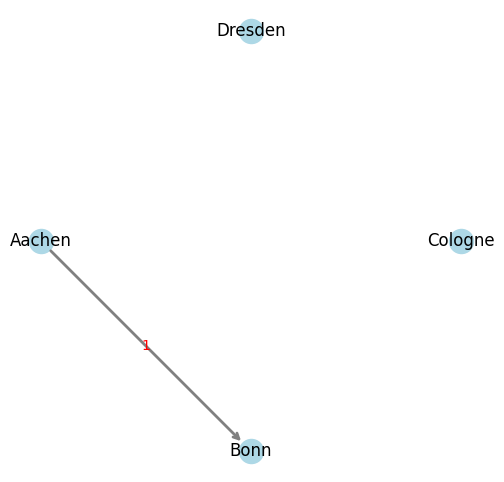

In [12]:
labels = ["Aachen", "Bonn", "Cologne", "Dresden"]

dg = DirectedGraph(labels)

dg.add_edge("Aachen", "Bonn")

print(dg.adj_matrix)
draw_graph(dg)

Is there a circle in our dungeon?  True


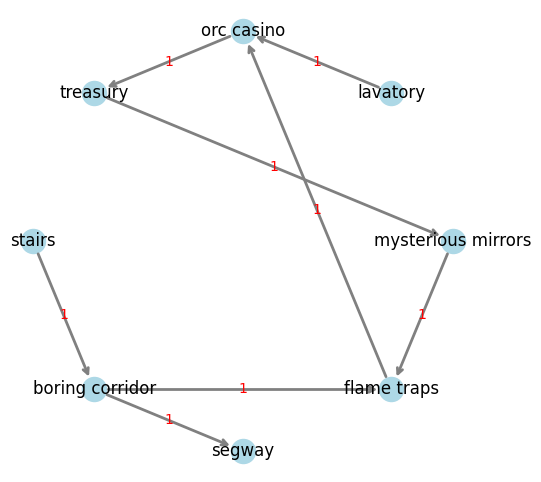

In [13]:
rooms = [
    "stairs",
    "boring corridor",
    "segway",
    "flame traps",
    "mysterious mirrors",
    "lavatory",
    "orc casino",
    "treasury",
]

dungeon = DirectedGraph(rooms)
dungeon.add_edge("orc casino", "treasury")
dungeon.add_edge(rooms[5], rooms[6])
dungeon.add_edge(rooms[3], rooms[6])
dungeon.add_edge("boring corridor", "flame traps")
dungeon.add_edge("stairs", "boring corridor")
dungeon.add_edge("boring corridor", "segway")
dungeon.add_edge("mysterious mirrors", "flame traps")
dungeon.add_edge("treasury", "mysterious mirrors")


# dungeon.dfs("flame traps")
# print("----------")
# dungeon.bfs("flame traps")

print("Is there a circle in our dungeon? ", dungeon.detect_cycle())
draw_graph(dungeon)

In [22]:
def bellman_ford(graph, start_label):
    """
    Compute shortest paths from 'start_label' in a directed graph
    that may have negative edges.

    Returns:
    {
      'paths': {
         label: { 'cost': float or None, 'path': [list_of_vertex_labels] }
      },
      'negative_cycle': bool
    }
    If 'negative_cycle' is True, the path costs may not be correct
    for vertices involved in that cycle.
    """

    # Extract metadata from the graph object
    labels = graph.labels
    n = graph.num_vertices

    # dist[i] stores the minimum cost found so far from start to node i
    dist = [float("inf")] * n
    # prev[i] stores the index of the node immediately preceding node i
    prev = [None] * n

    # Find the integer index of our starting string label
    start_index = labels.index(start_label)
    # Distance from start to itself is always 0
    dist[start_index] = 0

    # Outer loop: The maximum length of a simple path is n-1 edges.
    # Relaxing all edges n-1 times guarantees finding the shortest path.
    for _ in range(n - 1):
        # Iterate through every possible 'source' vertex u
        for u in range(n):
            # If u is unreachable, we can't use it to find a path to its neighbors
            if dist[u] == float("inf"):
                continue

            # Iterate through every possible 'destination' vertex v
            for v in range(n):
                weight = graph.adj_matrix[u][v]

                # Check if an edge exists (using 'is not None' to allow 0-weight edges)
                if weight is not None:
                    new_dist = dist[u] + weight

                    # If the path through u is cheaper than the best known path to v
                    if new_dist < dist[v]:
                        dist[v] = new_dist  # Update the minimum distance
                        prev[v] = u  # Record u as the parent of v

    # Final Pass: Check for negative cycles.
    # If we can still relax an edge on the n-th pass, a negative cycle exists.
    negative_cycle = False
    for u in range(n):
        if dist[u] == float("inf"):
            continue
        for v in range(n):
            weight = graph.adj_matrix[u][v]
            # If a shorter path is found now, the cost is actually -infinity
            if weight is not None and dist[u] + weight < dist[v]:
                negative_cycle = True
                break
        if negative_cycle:
            break

    # Build result
    result = {"paths": {}, "negative_cycle": negative_cycle}

    # Reconstruct each vertex's path from start, if reachable
    for i, label in enumerate(labels):
        if dist[i] == float("inf"):
            # Unreachable
            cost = None
            path = []
        elif negative_cycle:
            # If there's a cycle, we can't guarantee a simple path exists via 'prev'
            cost, path = dist[i], ["Error: Negative Cycle Detected"]
        else:
            cost = dist[i]
            # Reconstruct path by walking backwards via 'prev'
            path_indices = []
            current = i
            while current is not None:
                path_indices.append(current)
                current = prev[current]
            path_indices.reverse()  # now it's from start_index -> i

            path = [labels[idx] for idx in path_indices]

        result["paths"][label] = {"cost": cost, "path": path}

    return result

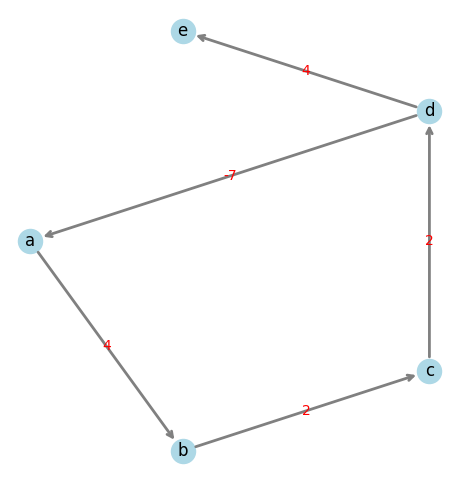

In [20]:
labels = ["a", "b", "c", "d", "e"]
g = DirectedGraph(labels)
g.add_edge("a", "b", 4)
g.add_edge("b", "c", 2)
g.add_edge("c", "d", 2)
g.add_edge("d", "a", -7)
g.add_edge("d", "e", 4)
draw_graph(g)

In [21]:
bellman_ford(g, "a")

{'paths': {'a': {'cost': 0, 'path': ['a']},
  'b': {'cost': 4, 'path': ['a', 'b']},
  'c': {'cost': 6, 'path': ['a', 'b', 'c']},
  'd': {'cost': 8, 'path': ['a', 'b', 'c', 'd']},
  'e': {'cost': 12, 'path': ['a', 'b', 'c', 'd', 'e']}},
 'negative_cycle': False}